# Reversal / Momentum - Time Horizon
In this homework, we explore how reversal tends to exist at shorter horizons and momentum at longer horizons. We do this on 4h cryptocurrency price data. Please first run the code below, which will download the price data (from Binance since 01/2020 to 12/2022) and compute returns based on it, stored in `ret`.

1. Use `ret` to generate rank-demeaned-normalized XS reversal strategies at 4,8,12,16,20, and 24 hour frequencies.
2. IE. for the 12 hour strategy, you will use the average return in the last three 4-hour bars to form a rank-demeaned-noramlzied XS portfolio and hold for the next 4 hours.
3. Compute the Sharpe ratios of the reversal strategy at these different horizons.
4. At what horizons do you observe reversal vs. momentum?
5. The first bar typically contains the most reversal. "Skip" the first bar by lagging your portfolio by one 4h bar (similar to how UMD does at the monthly frequency). This should strengthen any momentum you see.

In [2]:
from binance.client import Client as bnb_client
from datetime import datetime, timezone
import pandas as pd 
import numpy as np 

#client = bnb_client()
###  if you're in the US, use: 
client = bnb_client(tld='US')#" here instead

def get_binance_px(symbol,freq,start_ts = '2022-08-12'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.fromtimestamp(x/1000, tz=timezone.utc))
    data['close_time'] = data['close_time'].map(lambda x: datetime.fromtimestamp(x/1000, tz=timezone.utc))
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

C:\Users\mroha\AppData\Local\Temp\ipykernel_4068\193364202.py:11: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  data = client.get_historical_klines(symbol,freq,start_ts)
C:\Users\mroha\AppData\Local\Temp\ipykernel_4068\193364202.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [8]:
ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2022-08-12 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-12 04:00:00+00:00,-0.002232,-0.007980,0.001109,-0.000824,NaN,-0.006486,-0.009698
2022-08-12 08:00:00+00:00,-0.012102,-0.010549,-0.018095,-0.011183,NaN,-0.009793,-0.009793
2022-08-12 12:00:00+00:00,0.013096,0.016003,0.015331,0.012069,NaN,0.032967,0.010989
2022-08-12 16:00:00+00:00,0.008303,0.015435,0.012709,0.004365,NaN,0.001064,0.007609
...,...,...,...,...,...,...,...
2025-08-13 04:00:00+00:00,-0.000509,-0.004508,0.002801,0.010769,-0.000308,0.002893,0.000000
2025-08-13 08:00:00+00:00,0.009365,0.013323,0.024328,0.010998,0.014316,0.024038,0.000000
2025-08-13 12:00:00+00:00,0.004163,-0.005471,-0.007273,-0.011464,-0.010251,-0.015962,0.000000
2025-08-13 16:00:00+00:00,0.008637,0.015937,0.011905,0.002049,0.007315,0.007872,0.000000


In [4]:
strats = {}
for hor in [1,2,3,4,5,6]:
    avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats[hor] = (avg_ret.shift()*ret).sum(1)
strats = pd.DataFrame(strats)
strats

,1,2,3,4,5,6
2022-08-12 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-08-12 04:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-08-12 08:00:00+00:00,-0.002540,-0.002540,-0.002540,-0.002540,-0.002540,-0.002540
2022-08-12 12:00:00+00:00,0.003545,0.000795,0.000795,0.000795,0.000795,0.000795
2022-08-12 16:00:00+00:00,0.000272,-0.001428,-0.003908,-0.003908,-0.003908,-0.003908
...,...,...,...,...,...,...
2025-08-13 04:00:00+00:00,0.000352,-0.000125,0.000957,0.000301,0.000301,0.000301
2025-08-13 08:00:00+00:00,0.002699,0.003885,0.000048,0.005685,0.008445,0.007552
2025-08-13 12:00:00+00:00,-0.005071,-0.004869,-0.005273,-0.002174,-0.003525,-0.004774
2025-08-13 16:00:00+00:00,0.000568,0.003950,0.001806,0.003740,0.003654,0.003864


We get reversal at horizons of <=8 hours. Momentum exists at longer horizons.

In [5]:
sr = strats.mean()/strats.std()*np.sqrt(252*24/4)
sr

1   -2.072191
2   -0.842306
3   -0.681617
4   -0.077489
5   -0.191686
6    0.248107
dtype: float64

In [6]:
sr = strats.resample('A').mean()/strats.resample('A').std()*np.sqrt(252*24/4)

C:\Users\mroha\AppData\Local\Temp\ipykernel_4068\3817204765.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sr = strats.resample('A').mean()/strats.resample('A').std()*np.sqrt(252*24/4)


<Axes: >

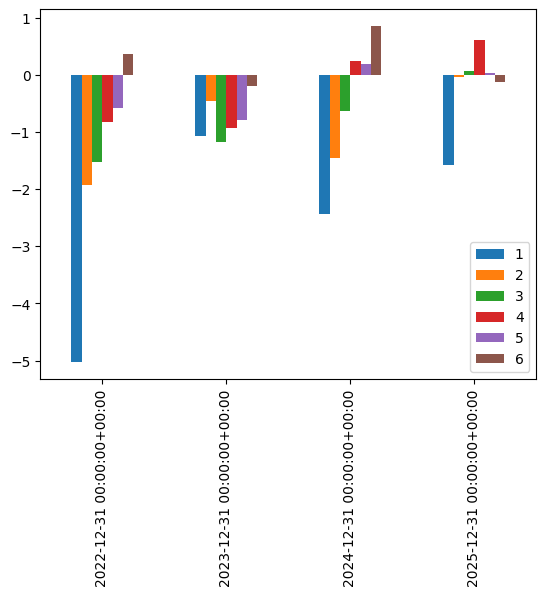

In [7]:
sr.plot(kind='bar')

In [9]:
strats_lag = {}
for hor in [1,2,3,4,5,6]:
    avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats_lag[hor] = (avg_ret.shift(2)*ret).sum(1)
strats_lag = pd.DataFrame(strats_lag)

Skipping the most recent bar bumps up the momentum effect significantly, and we now see positive sharpes as high as ~3.

In [10]:
sr_lag = strats_lag.mean()/strats_lag.std()*np.sqrt(252*24/4)
sr_lag

1    0.594301
2    0.524637
3    1.417769
4    0.459734
5    0.886650
6    1.136508
dtype: float64